  -> pm10
  -> pm25
  -> no2
  -> ozon
  -> russ
  -> laerm
✅ Saved fuzzy environmental quality map as: ../geoserver_data/data\zurich_fuzzy_quality.tif


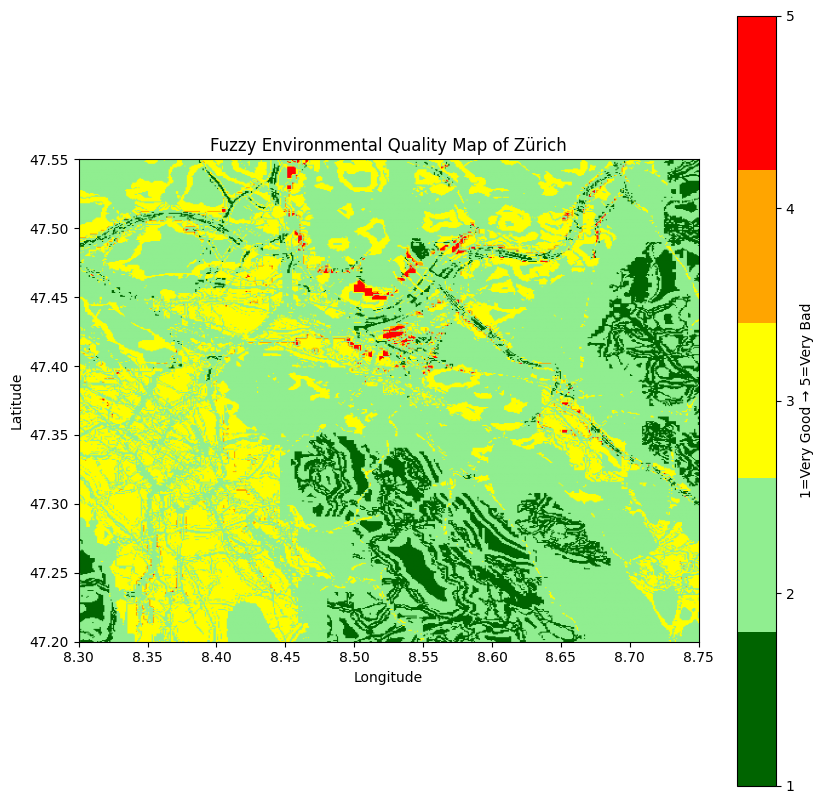

In [2]:
import rasterio
from rasterio.transform import from_bounds
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import requests
from matplotlib.colors import ListedColormap
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import os

# ------------------------------------------------------------
data_in_geoserver_folder = "../geoserver_data/data"
data_folder = "../fuzzy-script/data"
os.makedirs(data_folder, exist_ok=True)
os.makedirs(data_in_geoserver_folder, exist_ok=True)

# ------------------------------------------------------------
# Define area and layers
# ------------------------------------------------------------
bbox = (8.3, 47.2, 8.75, 47.55)
width, height = 512, 512  # resolution

layers = {
    "pm10": "https://wms.zh.ch/AwelLHPM10JahreZHWMS",
    "pm25": "https://wms.zh.ch/AwelLHPM25JahreZHWMS",
    "no2": "https://wms.zh.ch/AwelLHNO2JahreZHWMS",
    "ozon": "https://wms.zh.ch/AwelLHMP98JahreZHWMS",
    "russ": "https://wms.zh.ch/ImmissionenZHWMS",
    "laerm": "https://wms.geo.admin.ch/"
}

year = 2023
russ_year = 2020
layer_names = {
    "pm10": f"pm10-jahre-{year}",
    "pm25": f"pm25-jahre-{year}",
    "no2": f"no2-jahre-{year}",
    "ozon": f"mp98-jahre-{year}",
    "russ": f"bc-{russ_year}",
    "laerm": "ch.bafu.laerm-strassenlaerm_tag"
}

# ------------------------------------------------------------
# Download function (direct WMS for zh layers, else raster)
# ------------------------------------------------------------
def fetch_wms_image(url, layer_name, bbox, width, height, crs="EPSG:4326"):
    if "wms.zh.ch" in url:
        # Use direct image from WMS
        params = {
            "LAYERS": layer_name,
            "SERVICE": "WMS",
            "VERSION": "1.3.0",
            "REQUEST": "GetMap",
            "FORMAT": "image/png; mode=8bit",
            "CRS": "EPSG:2056",
            "BBOX": "2680000,1243000,2696931,1255698",  # fixed full Zurich bbox for PM10
            "WIDTH": 1600,
            "HEIGHT": 1200
        }
        r = requests.get(url, params=params)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content)).convert("L")
        local_path = os.path.join(data_folder, f"{layer_name}.png")
        img.save(local_path)
        arr = np.array(img).astype(float)
        arr = np.nan_to_num(arr, nan=0)
        # Resize to match workflow resolution
        arr = np.array(Image.fromarray(arr).resize((width, height)))
        return arr
    else:
        # Other WMS or sources (default)
        params = {
            "service": "WMS",
            "version": "1.3.0",
            "request": "GetMap",
            "layers": layer_name,
            "bbox": f"{bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]}" if "geo.admin.ch" in url else f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
            "width": width,
            "height": height,
            "crs": crs,
            "format": "image/png",
            "transparent": "true"
        }
        r = requests.get(url, params=params)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content)).convert("L")
        local_path = os.path.join(data_folder, f"{layer_name}.png")
        img.save(local_path)
        arr = np.array(img).astype(float)
        arr = np.nan_to_num(arr, nan=0)
        return arr

# ------------------------------------------------------------
# Download all layers
# ------------------------------------------------------------
print("Downloading layers...")
data = {}
for key in layers:
    print(f"  -> {key}")
    arr = fetch_wms_image(layers[key], layer_names[key], bbox, width, height)
    arr_norm = (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-6)
    data[key] = arr_norm

# ------------------------------------------------------------
# Fuzzy logic setup
# ------------------------------------------------------------
pm25 = ctrl.Antecedent(np.linspace(0, 1, 100), 'pm25')
pm10 = ctrl.Antecedent(np.linspace(0, 1, 100), 'pm10')
no2 = ctrl.Antecedent(np.linspace(0, 1, 100), 'no2')
ozon = ctrl.Antecedent(np.linspace(0, 1, 100), 'ozon')
russ = ctrl.Antecedent(np.linspace(0, 1, 100), 'russ')
laerm = ctrl.Antecedent(np.linspace(0, 1, 100), 'laerm')
quality = ctrl.Consequent(np.linspace(0, 100, 100), 'quality')

for var in [pm25, pm10, no2, ozon, russ, laerm]:
    var['good'] = fuzz.trimf(var.universe, [0, 0, 0.3])
    var['moderate'] = fuzz.trimf(var.universe, [0.2, 0.5, 0.8])
    var['bad'] = fuzz.trimf(var.universe, [0.6, 1, 1])

quality['very_good'] = fuzz.trimf(quality.universe, [0, 0, 20])
quality['good'] = fuzz.trimf(quality.universe, [15, 30, 45])
quality['liveable'] = fuzz.trimf(quality.universe, [40, 55, 70])
quality['bad'] = fuzz.trimf(quality.universe, [65, 80, 90])
quality['very_bad'] = fuzz.trimf(quality.universe, [85, 100, 100])

rules = [
    ctrl.Rule(pm25['bad'] | pm10['bad'] | no2['bad'] | ozon['bad'] | russ['bad'] | laerm['bad'], quality['very_bad']),
    ctrl.Rule(pm25['moderate'] | pm10['moderate'] | no2['moderate'] | ozon['moderate'] | laerm['moderate'], quality['liveable']),
    ctrl.Rule(pm25['good'] & pm10['good'] & no2['good'] & russ['good'] & ozon['good'] & laerm['good'], quality['very_good']),
]

quality_ctrl = ctrl.ControlSystem(rules)
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)

# ------------------------------------------------------------
# Apply fuzzy logic
# ------------------------------------------------------------
h, w = data['pm25'].shape
fuzzy_output = np.zeros((h, w))

for i in range(h):
    for j in range(w):
        quality_sim.input['pm25'] = data['pm25'][i, j]
        quality_sim.input['pm10'] = data['pm10'][i, j]
        quality_sim.input['no2'] = data['no2'][i, j]
        quality_sim.input['ozon'] = data['ozon'][i, j]
        quality_sim.input['russ'] = data['russ'][i, j]
        quality_sim.input['laerm'] = data['laerm'][i, j]
        try:
            quality_sim.compute()
            fuzzy_output[i, j] = quality_sim.output['quality']
        except:
            fuzzy_output[i, j] = np.nan

# ------------------------------------------------------------
# Export GeoTIFF
# ------------------------------------------------------------
output_path = os.path.join(data_in_geoserver_folder, "zurich_fuzzy_quality.tif")
transform = from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], w, h)

with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=h,
    width=w,
    count=1,
    dtype=fuzzy_output.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(fuzzy_output, 1)

print(f"✅ Saved fuzzy environmental quality map as: {output_path}")

# ------------------------------------------------------------
# 7️⃣ Visualize without tile borders
# ------------------------------------------------------------
norm_output = (fuzzy_output - np.nanmin(fuzzy_output)) / (np.nanmax(fuzzy_output) - np.nanmin(fuzzy_output))
classes = np.zeros_like(norm_output)
classes[(norm_output < 0.2)] = 1
classes[(norm_output >= 0.2) & (norm_output < 0.4)] = 2
classes[(norm_output >= 0.4) & (norm_output < 0.6)] = 3
classes[(norm_output >= 0.6) & (norm_output < 0.8)] = 4
classes[(norm_output >= 0.8)] = 5

cmap = ListedColormap(["darkgreen", "lightgreen", "yellow", "orange", "red"])
plt.figure(figsize=(10, 10))
plt.imshow(classes, cmap=cmap, extent=[bbox[0], bbox[2], bbox[1], bbox[3]])
plt.title("Fuzzy Environmental Quality Map of Zürich")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(ticks=[1,2,3,4,5], label="1=Very Good → 5=Very Bad")
plt.show()
